# Style Transfer

In this notebook, I will recreate a style transfer method based on the paper, Image Style Transfer Using Convolutional Neural Networks, by Gatys in PyTorch.

In this paper, style transfer uses the features found in the 19-layer VGG Network, which is comprised of a series of convolutional and pooling layers, and a few fully-connected layers. In the image below, the convolutional layers are named by stack and their order in the stack. Conv_1_1 is the first convolutional layer that an image is passed through, in the first stack. Conv_2_1 is the first convolutional layer in the second stack.
The deepest convolutional layer in the network is conv_5_4.

I'll separate the style and content of the image to be used in this project because style transfer relies on this.

Given one content image and one style image, we aim to create a new, target image which should contain our desired content and style components:

objects and their arrangement are similar to that of the content image
style, colors, and textures are similar to that of the style image

## Import the relevant libraries

In [1]:
#import relevant libraries
%matplotlib inline

import os

from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
import requests
from torchvision import transforms, models

## Load in VGG19(features)

VGG19 is split into two portions:

vgg19.features, which are all the convolutional and pooling layers
vgg19.classifier, which are the three linear, classifier layers at the end
I only need the features portion, which I'm going to load in and "freeze" the its weights below.

In [2]:
#extract the features part of the vgg19 pe-trained model
model_transfer = models.vgg19(pretrained=True).features

##freeze all the VGG parameters because I will only optimize the target image
for param in model_transfer.parameters():
    param.requires_grad_(False)

In [3]:
# move the model to GPU, if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_transfer.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

## Load in Content (your chosen image) and Style (painting) Images

In [4]:
def load_image(img_path, max_size=400, shape=None):
    ''' Load in and transform an image, making sure the image
       is <= 400 pixels in the x-y dims.'''
    if "http" in img_path:
        response = requests.get(img_path)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(img_path).convert('RGB')
    
    # large images will slow down processing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
        
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image

Next, I'm loading in images by file name and forcing the style image to be the same size as the content image.

In [5]:
# load in content and style image
content = load_image('images/my_face.jpg').to(device)
# Resize style to match content, makes code easier
style = load_image('images/torsion_and_rotation.jpg', shape=content.shape[-2:]).to(device)

In [6]:
# helper function for un-normalizing an image 
# and converting it from a Tensor image to a NumPy image for display
def im_convert(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

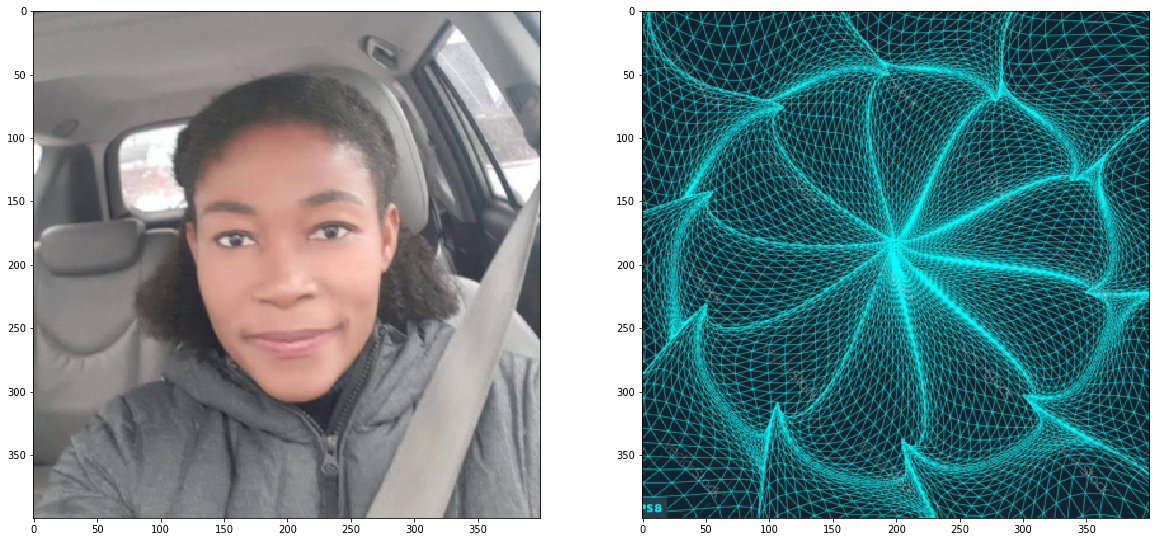

In [7]:
# display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# content and style ims side-by-side
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

## VGG19 Layers
To get the content and style representations of an image, I have to pass an image forward through the VGG19 network until I get to the desired layer(s) and then get the output from that layer.

I would like to print out the VGG19 structure. This will help me see the names of the various layers of the network.

In [8]:
print(model_transfer)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

## Content and Style Features

For the content and style representation, I will have to completely map the layers by names to names according to the paper.

In [9]:
def get_features(image, model, layers=None):
    """ Run an image forward through a model and get the features for 
        a set of layers. Default layers are for VGGNet matching Gatys et al (2016)
    """
    
    ## The layers are mapped according to names of PyTorch's VGGNet to names from the paper
    # Look out for the conv layers after each Max pooling 
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2',  ## content representation
                  '28': 'conv5_1'}
        
    features = {}
    x = image
    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

## Gram Matrix

The output of every convolutional layer is a Tensor with dimensions associated with the batch_size, a depth, d and some height and width (h, w). The Gram matrix of a convolutional layer can be calculated as follows:

Get the depth, height, and width of a tensor using batch_size, d, h, w = tensor.size
Reshape that tensor so that the spatial dimensions are flattened
Calculate the gram matrix by multiplying the reshaped tensor by it's transpose
Note: Two matrices can be multiplied two using torch.mm(matrix1, matrix2).

In [10]:
def gram_matrix(tensor):
    """ Calculate the Gram Matrix of a given tensor 
        Gram Matrix: https://en.wikipedia.org/wiki/Gramian_matrix
    """
    
    # get the batch_size, depth, height, and width of the Tensor
    _, d, h, w = tensor.size()
    
    # reshape so we're multiplying the features for each channel
    tensor = tensor.view(d, h * w)
    
    # calculate the gram matrix
    gram = torch.mm(tensor, tensor.t())
    
    return gram 

## Write Function To Extract the features

I'll write functions for extracting features from the images and computing the gram matrix of a given convolutional layer for the style representation.

In [11]:
# get content and style features only once before training
content_features = get_features(content, model_transfer)
style_features = get_features(style, model_transfer)

# calculate the gram matrices for each layer of our style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# create a third "target" image and prep it for change
# it is a good idea to start off with the target as a copy of our *content* image
# then iteratively change its style
target = content.clone().requires_grad_(True).to(device)

## Loss and Weights

**Individual Layer Style Weights**

I can weight the style representation at each relevant layer by using  a range between 0-1 to weight these layers. 

By weighting earlier layers (conv1_1 and conv2_1) more, I can expect to get larger style artifacts in my resulting, target image. 

If I choose to weight later layers, I'll get more emphasis on smaller features. This is because each layer is a different size and together they create a multi-scale style representation!

**Content and Style Weight**
Just like in the paper, I will define an alpha (content_weight) and a beta (style_weight). 

This ratio will affect how stylized my final image is. It's recommended that you leave the content_weight = 1 and set the style_weight to achieve the ratio I want.

In [12]:
# weights for each style layer 
# weighting earlier layers more will result in *larger* style artifacts
# notice we are excluding `conv4_2` our content representation
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1  # alpha
style_weight = 1e6  # beta

## Updating the Target and Calculating Losses

Here, I'll decide onthe number of steps for which to update my image.
In this case, I'm only changing my target image and nothing more. It is recommended that at least 2000 steps are used for good results.

Inside the iteration loop, the content and style losses will be calculated and update my target image, accordingly.

**Content Loss**
The content loss will be the mean squared difference between the target and content features at layer conv4_2. This can be calculated as follows:

content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)

**Style Loss**
The style loss is calculated in a similar way, in which I will have to iterate through a number of layers, specified by name in the dictionary style_weights.

**Total Loss**
Finally, I'll create the total loss by adding up the style and content losses and weighting them with my specified alpha and beta!

Intermittently, I'll print out this loss.

It takes some time for an image's style to change, so the losses may be very large.

I'll just focus on the appearance of my target image rather than any loss value. Still, I expect to see the losses decrease over some number of iterations.

Total loss:  537579136.0


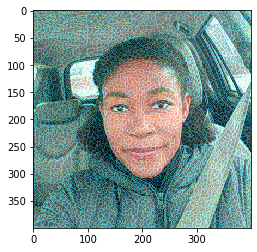

Total loss:  70103536.0


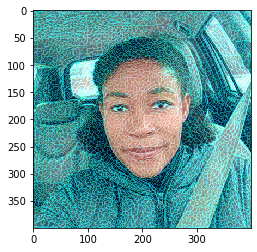

Total loss:  35389728.0


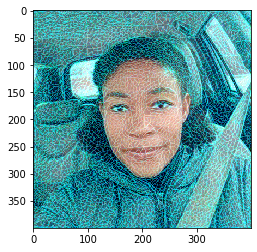

Total loss:  24801832.0


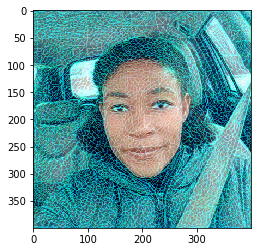

In [ ]:
# for displaying the target image, intermittently
show_every = 400

# iteration hyperparameters
optimizer = optim.Adam([target], lr=0.003)
steps = 2000  # decide how many iterations to update your image (5000)

for ii in range(1, steps+1):
    
    # get the features from your target image
    target_features = get_features(target, model_transfer)
    
    # the content loss
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    
    # the style loss
    # initialize the style loss to 0
    style_loss = 0
    # then add to it for each layer's gram matrix loss
    for layer in style_weights:
        # get the "target" style representation for the layer
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        # get the "style" style representation
        style_gram = style_grams[layer]
        # the style loss for one layer, weighted appropriately
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        # add to the style loss
        style_loss += layer_style_loss / (d * h * w)
        
    # calculate the *total* loss
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    # update your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # display intermediate images and print the loss
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

## Display the Target Image

In [ ]:
# display content and final, target image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(target))